In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
from torchvision.transforms import v2
import timm
from transformers import get_cosine_schedule_with_warmup
from tqdm import tqdm
import kagglehub

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from torchvision.transforms import functional as F
# from torchvision.transforms import InterpolationMode
# import torchvision.transforms.functional as F
import torchvision.models as models
from torchvision.io import read_image

In [ ]:
# Download entire IMAGE dataset
image_base_path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

Using Colab cache for faster access to the 'ai-vs-human-generated-dataset' dataset.


In [ ]:
IMAGE_BASE_DIR = Path(image_base_path)
IMAGE_BASE_DIR

PosixPath('/kaggle/input/ai-vs-human-generated-dataset')

In [ ]:
image_df_path = os.path.join(IMAGE_BASE_DIR, 'train.csv')
image_df = pd.read_csv(image_df_path)
image_df.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [ ]:
X, y = image_df[['file_name']], image_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
class Letterbox:
    def __init__(self, size, fill_color=(128,128,128), fill=128):
        self.size = size  # (Width, Height)
        self.fill_color = fill_color
        self.fill = fill

    def __call__(self, img):
        _, h, w = img.shape
        target_w, target_h = self.size
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        img = F.resize(img, (new_h, new_w), interpolation=F.InterpolationMode.BILINEAR)
        padded = torch.full((3, target_h, target_w), self.fill / 255.0, device=img.device)
        top = (target_h - new_h) // 2
        left = (target_w - new_w) // 2
        padded[:, top:top+new_h, left:left+new_w] = img
        return padded

In [ ]:
TARGET_SIZE = (224, 224)

# ---- ViT standardization ----
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_transform = v2.Compose([
    v2.ToImage(),
    Letterbox(TARGET_SIZE),
    v2.ToTensor(),
    # v2.Normalize(MEAN, STD)
])
test_transform = v2.Compose([
    v2.ToImage(),
    Letterbox(TARGET_SIZE),
    v2.ToTensor(),
    # v2.Normalize(MEAN, STD)
])

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
train_transform_aug = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    v2.ToTensor(),
    Letterbox(TARGET_SIZE),
    # v2.Normalize(mean=MEAN, std=STD)
])

In [ ]:
class AIImageDataset(Dataset):
    def __init__(self, X, y, root_dir, transform=None):
        self.X = X
        self.y = y
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        file_name = self.X.iloc[idx]['file_name']
        img_path = os.path.join(self.root, file_name)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(self.y.iloc[idx])
        return img, label

In [ ]:
train_dataset = AIImageDataset(X_train, y_train, IMAGE_BASE_DIR, transform=train_transform)
train_dataset_aug = AIImageDataset(X_train, y_train, IMAGE_BASE_DIR, transform=train_transform_aug)
test_dataset  = AIImageDataset(X_test, y_test, IMAGE_BASE_DIR, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.should_stop = True

In [ ]:
def get_vit_model(pretrained=False):
    model = timm.create_model("vit_base_patch16_224", pretrained=pretrained, num_classes=1)
    return model

In [ ]:
def train_image_model_vit(data_loader, model, epochs=5, lr=1e-4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, accuracies = [], []

    for i in range(epochs):
        model.train()
        running_loss, running_acc = 0.0, 0.0
        for X_batch, y_batch in tqdm(data_loader, desc=f"Epoch {i+1}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            logits = model(X_batch).squeeze(1)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(logits) >= 0.5).long()
            running_acc += (preds == y_batch).float().mean().item()

        epoch_loss = running_loss / len(data_loader)
        epoch_acc = running_acc / len(data_loader)
        print(f"Epoch {i+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4%}")
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

    return model, losses, accuracies

In [ ]:
def train_image_model_vit(data_loader, model, epochs=5, lr=3e-4, patience=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, accuracies = [], []

    best_loss = float("inf")
    best_state = None
    wait = 0

    for i in range(epochs):
        model.train()
        running_loss, running_acc = 0.0, 0.0

        for X_batch, y_batch in tqdm(data_loader, desc=f"Epoch {i+1}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()

            logits = model(X_batch).squeeze(1)
            loss = loss_fn(logits, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(logits) >= 0.5).long()
            running_acc += (preds == y_batch).float().mean().item()

        epoch_loss = running_loss / len(data_loader)
        epoch_acc = running_acc / len(data_loader)

        print(f"Epoch {i+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4%}")
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            print(f"  → EarlyStopping wait = {wait}/{patience}")

            if wait >= patience:
                print("  → EarlyStopping triggered, restoring best model.")
                model.load_state_dict(best_state)
                break

    return model, losses, accuracies


In [ ]:
def evaluate(model, data_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    running_acc = 0.0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch).squeeze(1)
            preds = (torch.sigmoid(logits) >= 0.5).long()
            running_acc += (preds == y_batch).float().mean().item()
    return running_acc / len(data_loader)

In [16]:
model_pretrained = get_vit_model(pretrained=True)
model_pretrained, losses1, acc1 = train_image_model_vit(train_loader, model_pretrained, epochs=15, lr=1e-5)

model_scratch = get_vit_model(pretrained=False)
model_scratch, losses2, acc2 = train_image_model_vit(train_loader, model_scratch, epochs=15, lr=1e-4)

model_scratch_aug = get_vit_model(pretrained=False)
model_scratch_aug, losses3, acc3 = train_image_model_vit(train_loader_aug, model_scratch_aug, epochs=15, lr=1e-4)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 875/875 [05:59<00:00,  2.43it/s]


Epoch 1: Loss=0.3215, Acc=85.8800%


Epoch 2: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 2: Loss=0.2173, Acc=91.0782%


Epoch 3: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 3: Loss=0.1734, Acc=93.0336%


Epoch 4: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 4: Loss=0.1428, Acc=94.3482%


Epoch 5: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 5: Loss=0.1191, Acc=95.2411%


Epoch 6: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 6: Loss=0.0961, Acc=96.2696%


Epoch 7: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 7: Loss=0.0779, Acc=97.0179%


Epoch 8: 100%|██████████| 875/875 [05:56<00:00,  2.45it/s]


Epoch 8: Loss=0.0599, Acc=97.6768%


Epoch 9: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 9: Loss=0.0479, Acc=98.1107%


Epoch 10: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 10: Loss=0.0357, Acc=98.6804%


Epoch 11: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 11: Loss=0.0277, Acc=98.9443%


Epoch 12: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 12: Loss=0.0269, Acc=99.0196%


Epoch 13: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 13: Loss=0.0295, Acc=98.8964%
  → EarlyStopping wait = 1/3


Epoch 14: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 14: Loss=0.0237, Acc=99.1161%


Epoch 15: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 15: Loss=0.0199, Acc=99.2500%


Epoch 1: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 1: Loss=0.4082, Acc=80.8707%


Epoch 2: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 2: Loss=0.2525, Acc=89.4885%


Epoch 3: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 3: Loss=0.2151, Acc=91.2121%


Epoch 4: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 4: Loss=0.1941, Acc=92.2961%


Epoch 5: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 5: Loss=0.1773, Acc=92.9443%


Epoch 6: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 6: Loss=0.1668, Acc=93.3107%


Epoch 7: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 7: Loss=0.1613, Acc=93.6446%


Epoch 8: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 8: Loss=0.1469, Acc=94.2696%


Epoch 9: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 9: Loss=0.1380, Acc=94.5728%


Epoch 10: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 10: Loss=0.1293, Acc=94.9554%


Epoch 11: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 11: Loss=0.1274, Acc=95.0107%


Epoch 12: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 12: Loss=0.1206, Acc=95.2643%


Epoch 13: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 13: Loss=0.1150, Acc=95.4286%


Epoch 14: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 14: Loss=0.1109, Acc=95.6982%


Epoch 15: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 15: Loss=0.1077, Acc=95.9036%


Epoch 1: 100%|██████████| 875/875 [05:57<00:00,  2.44it/s]


Epoch 1: Loss=0.5229, Acc=74.0757%


Epoch 2: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 2: Loss=0.4261, Acc=80.5060%


Epoch 3: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 3: Loss=0.4009, Acc=81.9578%


Epoch 4: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 4: Loss=0.3854, Acc=82.7489%


Epoch 5: 100%|██████████| 875/875 [05:57<00:00,  2.44it/s]


Epoch 5: Loss=0.3752, Acc=83.3039%


Epoch 6: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 6: Loss=0.3686, Acc=83.5253%


Epoch 7: 100%|██████████| 875/875 [05:58<00:00,  2.44it/s]


Epoch 7: Loss=0.3582, Acc=84.0635%


Epoch 8: 100%|██████████| 875/875 [05:58<00:00,  2.44it/s]


Epoch 8: Loss=0.3510, Acc=84.6671%


Epoch 9: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 9: Loss=0.3450, Acc=84.8700%


Epoch 10: 100%|██████████| 875/875 [05:58<00:00,  2.44it/s]


Epoch 10: Loss=0.3430, Acc=84.8721%


Epoch 11: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 11: Loss=0.3402, Acc=85.2443%


Epoch 12: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 12: Loss=0.3316, Acc=85.4885%


Epoch 13: 100%|██████████| 875/875 [05:57<00:00,  2.44it/s]


Epoch 13: Loss=0.3272, Acc=85.7260%


Epoch 14: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]


Epoch 14: Loss=0.3215, Acc=86.1364%


Epoch 15: 100%|██████████| 875/875 [05:57<00:00,  2.45it/s]

Epoch 15: Loss=0.3153, Acc=86.4521%


In [17]:
test_acc1 = evaluate(model_pretrained, test_loader)
test_acc2 = evaluate(model_scratch, test_loader)
test_acc3 = evaluate(model_scratch_aug, test_loader)

print(f"Pretrained ViT Test Acc: {test_acc1:.2%}")
print(f"Scratch ViT Test Acc: {test_acc2:.2%}")
print(f"Scratch+Aug ViT Test Acc: {test_acc3:.2%}")

Pretrained ViT Test Acc: 92.91%
Scratch ViT Test Acc: 93.04%
Scratch+Aug ViT Test Acc: 87.25%


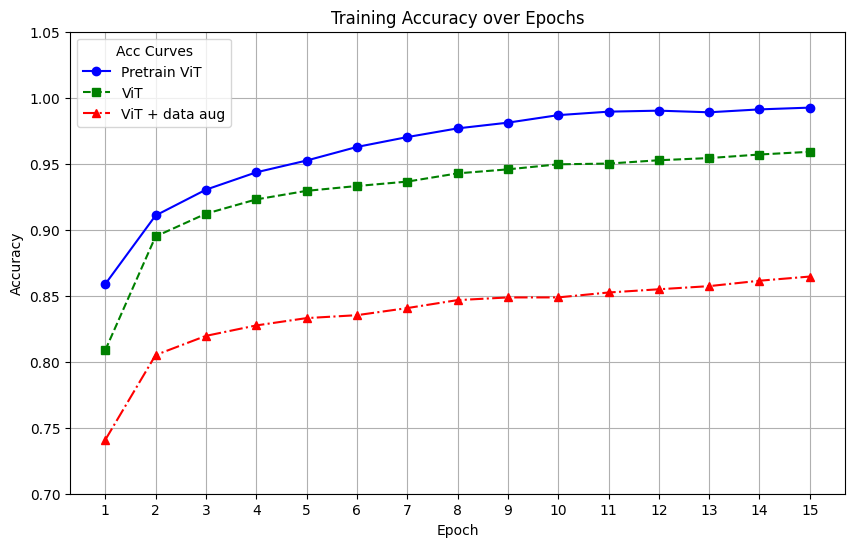

In [23]:
import matplotlib.pyplot as plt
epochs = range(1, len(acc1)+1)

plt.figure(figsize=(10,6))
plt.plot(epochs, acc1, marker='o', linestyle='-', label='Pretrain ViT', color='blue')
plt.plot(epochs, acc2, marker='s', linestyle='--', label='ViT', color='green')
plt.plot(epochs, acc3, marker='^', linestyle='-.', label='ViT + data aug', color='red')

plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.05)
plt.xticks(epochs)
plt.grid(True)
plt.legend(title='Acc Curves')
plt.show()
